# 02. Feature Engineering
**Project:** Climate-Sensitive Health Forecasting (Dengue - Davao Pilot\
**Author:** Edsequille Publico

### **Goal**
To transform raw time-series data into supervised learning features.

### **The Science**
1.  **Lag Features:** Dengue outbreaks lag behind rainfall by 4-8 weeks (mosquito breeding cycle). We create features like `rain_lag_4w` to capture this.
2.  **Rolling Windows:** A single rainy day doesn't cause an outbreak; a wet *month* does. We use rolling sums/means to capture accumulated risks.
3.  **Seasonality:** Adding `Month` and `WeekOfYear` helps the model learn annual cycles (e.g., the "Ber" months).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Settings
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)

# Paths
PROCESSED_DIR = '/kaggle/input/davao-dengue-merged'
INPUT_FILE = os.path.join(PROCESSED_DIR, '01_davao_dengue_merged.csv')

# Load Data
# Crucial: Parse dates and set index immediately
df = pd.read_csv(INPUT_FILE, index_col='date', parse_dates=True)

print(f"✅ Data Loaded. Shape: {df.shape}")
df.head()

✅ Data Loaded. Shape: (780, 6)


,rainfall,tmean,tmax,tmin,rh,cases
date,,,,,,
2008-01-07,47.900000,26.098938,30.924809,23.386721,80.343169,37
2008-01-14,42.224153,25.541390,29.315301,22.974372,82.828642,41
2008-01-21,58.095738,25.510320,30.756011,22.703934,84.362920,31
2008-01-28,8.076940,25.937205,30.670874,22.307869,77.338751,32
2008-02-04,0.313607,26.213856,31.405738,22.574372,77.015293,44


In [2]:
# --- 1. LAG FEATURES ( The Mosquito Cycle) ---
# We shift the climate data forward to mimic biological delays.
# If it rains today, mosquitoes bite in 4-8 weeks.

df_eng = df.copy()

# Variables to lag
climate_cols = ['rainfall', 'tmean', 'tmax', 'rh']

# Lag Periods (in Weeks)
# 4 weeks = 1 month (Larval development)
# 8 weeks = 2 months (Transmission cycle)
# 12 weeks = 3 months (Long term buildup)
lags = [4, 8, 12] 

for col in climate_cols:
    for lag in lags:
        # Create new column, e.g., 'rainfall_lag4'
        df_eng[f'{col}_lag{lag}w'] = df_eng[col].shift(lag)

# Auto-Correlation Lags
# The best predictor of cases next week is often cases this week (trend)
df_eng['cases_lag1w'] = df_eng['cases'].shift(1)
df_eng['cases_lag2w'] = df_eng['cases'].shift(2)

print("✅ Lag Features Created.")
# Show example of shifting
df_eng[['rainfall', 'rainfall_lag4w']].head(6)

✅ Lag Features Created.


,rainfall,rainfall_lag4w
date,,
2008-01-07,47.900000,NaN
2008-01-14,42.224153,NaN
2008-01-21,58.095738,NaN
2008-01-28,8.076940,NaN
2008-02-04,0.313607,47.900000
2008-02-11,46.977322,42.224153


In [3]:
# --- 2. ROLLING AGGREGATES (Accumulated Risk) ---
# We want to know: "Did it rain a lot over the LAST MONTH?"
# not just "Did it rain yesterday?"

# Rolling Sum for Rainfall (Accumulation)
df_eng['rain_roll_sum_4w'] = df_eng['rainfall'].rolling(window=4).sum()
df_eng['rain_roll_sum_8w'] = df_eng['rainfall'].rolling(window=8).sum()

# Rolling Mean for Temperature (Sustained Heat)
df_eng['temp_roll_mean_4w'] = df_eng['tmean'].rolling(window=4).mean()
df_eng['rh_roll_mean_4w'] = df_eng['rh'].rolling(window=4).mean()

print("✅ Rolling Features Created.")

✅ Rolling Features Created.


In [4]:
# --- 3. TIME FEATURES (Seasonality) ---
# Help the model learn annual patterns (e.g., outbreaks usually happen in Q3)

df_eng['month'] = df_eng.index.month
df_eng['week_of_year'] = df_eng.index.isocalendar().week.astype(int)
df_eng['quarter'] = df_eng.index.quarter

# Drop NaN values created by lags
# (The first 12 weeks will be empty because they don't have enough history)
df_clean = df_eng.dropna()

print(f"✅ Time Features Added. Rows remaining after dropping NaN: {len(df_clean)}")

✅ Time Features Added. Rows remaining after dropping NaN: 768


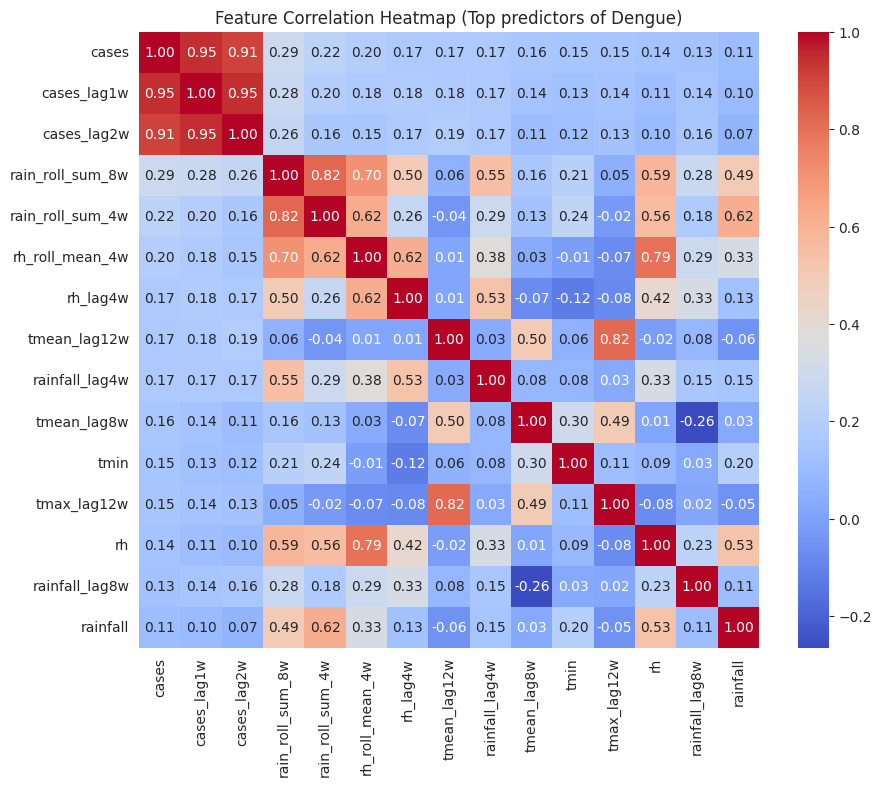


--- Top Predictors ---
cases               1.000000
cases_lag1w         0.948767
cases_lag2w         0.908516
rain_roll_sum_8w    0.285771
rain_roll_sum_4w    0.224656
rh_roll_mean_4w     0.198896
rh_lag4w            0.170416
tmean_lag12w        0.169629
rainfall_lag4w      0.169017
tmean_lag8w         0.157292
Name: cases, dtype: float64


In [5]:
# --- 4. CORRELATION ANALYSIS ---
# Which features actually predict Dengue?

# Calculate correlation with the Target ('cases')
corr_matrix = df_clean.corr()
target_corr = corr_matrix['cases'].sort_values(ascending=False)

# Plot Heatmap of Top 15 correlations
top_features = target_corr.index[:15] # Top 15 positively correlated

plt.figure(figsize=(10, 8))
sns.heatmap(df_clean[top_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap (Top predictors of Dengue)')
plt.show()

# Print specific correlations
print("\n--- Top Predictors ---")
print(target_corr.head(10))

In [7]:
# --- 5. EXPORT ---

output_file = '02_features.csv'
df_clean.to_csv(output_file)

print(f"✅ Feature Engineering Complete.")
print(f"Saved to: {output_file}")
print("🚀 Ready for Notebook 03: Modeling")

✅ Feature Engineering Complete.
Saved to: 02_features.csv
🚀 Ready for Notebook 03: Modeling
